# Predicción de Tiempos por Vuelta en F1

Este notebook implementa modelos predictivos para estimar el tiempo por vuelta de los coches de F1 en función de diversas variables como el tipo de neumático, condiciones meteorológicas, y estado de la pista.

## Objetivos
1. Cargar y preprocesar datos de FastF1 y OpenF1
2. Realizar feature engineering para potenciar la capacidad predictiva
3. Incluir análisis de degradación de neumáticos y paradas en boxes
4. Entrenar modelos de predicción (XGBoost y opcionalmente una Red Neuronal)
5. Evaluar el rendimiento y visualizar resultados

## 1. Importación de Librerías

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Configuración de visualización
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configuración de fastf1
fastf1.Cache.enable_cache('../f1-strategy/f1_cache')  # Asegúrate de que esta carpeta exista

# Crear directorios para outputs y models si no existen
os.makedirs('../outputs/week3', exist_ok=True)
os.makedirs('../models/week3', exist_ok=True)

## 2. Definición de Modelos

In [341]:
# Clase para el modelo PyTorch
class LapTimeNN(nn.Module):
    def __init__(self, input_size):
        super(LapTimeNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

## 3. Carga y Preparación de Datos

Vamos a cargar los datos desde los archivos Parquet que tenemos disponibles:
- laps.parquet: Contiene información sobre vueltas individuales
- weather.parquet: Contiene información meteorológica
- intervals.parquet: Contiene información sobre gaps y estados de carrera
- pitstops.parquet: Contiene información sobre paradas en boxes

In [342]:
def load_all_data():
    """
    Carga todos los datasets desde archivos parquet, verifica duplicaciones
    y los devuelve como DataFrames
    """
    # Definir rutas a los archivos
    laps_path = "../f1-strategy/data/raw/Spain_2023_laps.parquet"
    weather_path = "../f1-strategy/data/raw/Spain_2023_weather.parquet"
    intervals_path = "../f1-strategy/data/raw/Spain_2023_openf1_intervals.parquet"
    pitstops_path = "../f1-strategy/data/raw/Spain_2023_pitstops.parquet"
    
    # Cargar DataFrames
    laps_df = pd.read_parquet(laps_path)
    weather_df = pd.read_parquet(weather_path)
    intervals_df = pd.read_parquet(intervals_path)
    pitstops_df = pd.read_parquet(pitstops_path)
    
    # Imprimir información sobre columnas duplicadas
    print("Verificando posibles columnas duplicadas entre datasets:")
    
    # Comparar columnas entre cada par de DataFrames
    all_dfs = {
        'laps_df': laps_df,
        'weather_df': weather_df, 
        'intervals_df': intervals_df, 
        'pitstops_df': pitstops_df
    }
    
    for name1, df1 in all_dfs.items():
        for name2, df2 in all_dfs.items():
            if name1 >= name2:  # Evitar comparaciones duplicadas
                continue
                
            common_cols = set(df1.columns).intersection(set(df2.columns))
            if common_cols:
                print(f"Columnas comunes entre {name1} y {name2}: {common_cols}")
                
                # Verificar si las columnas tienen los mismos datos
                for col in common_cols:
                    if col in df1.columns and col in df2.columns:
                        # Para verificar sólo si están en ambos datasets y tienen valores compartidos
                        # Por simplicidad, solo verificamos algunos valores de ejemplo
                        try:
                            value1 = df1[col].iloc[0] if len(df1) > 0 else None
                            value2 = df2[col].iloc[0] if len(df2) > 0 else None
                            print(f"  - Columna '{col}': Ejemplo valor en {name1}: {value1}, en {name2}: {value2}")
                        except:
                            print(f"  - Columna '{col}': No se pudo comparar valores")
    
    return laps_df, weather_df, intervals_df, pitstops_df

In [343]:
# Load and unpack de data in different dataframes
laps_df, weather_df, intervals_df, pitstops_df = load_all_data()



Verificando posibles columnas duplicadas entre datasets:
Columnas comunes entre laps_df y weather_df: {'Time'}
  - Columna 'Time': Ejemplo valor en laps_df: 0 days 01:03:40.152000, en weather_df: 0 days 00:00:27.686000
Columnas comunes entre laps_df y pitstops_df: {'PitInTime', 'SpeedST', 'Deleted', 'Sector3Time', 'Stint', 'Sector1Time', 'DriverNumber', 'FreshTyre', 'PitOutTime', 'Time', 'DeletedReason', 'Driver', 'FastF1Generated', 'LapStartTime', 'TrackStatus', 'TyreLife', 'SpeedI1', 'IsPersonalBest', 'Team', 'Sector3SessionTime', 'SpeedFL', 'LapNumber', 'Sector2Time', 'Position', 'Sector2SessionTime', 'LapTime', 'Compound', 'IsAccurate', 'SpeedI2', 'LapStartDate', 'Sector1SessionTime'}
  - Columna 'PitInTime': Ejemplo valor en laps_df: NaT, en pitstops_df: 0 days 01:37:06.753000
  - Columna 'SpeedST': Ejemplo valor en laps_df: 275.0, en pitstops_df: nan
  - Columna 'Deleted': Ejemplo valor en laps_df: False, en pitstops_df: False
  - Columna 'Sector3Time': Ejemplo valor en laps_df: 

In [344]:
# Show info about shape of the datafarmes

print(f"laps_df shape: {laps_df.shape} \n")

print(f"weather_df shape: {weather_df.shape} \n")

print(f"intervals_df shape: {intervals_df.shape} \n")

print(f"pitstops_df shape: {pitstops_df.shape} \n")



laps_df shape: (1312, 31) 

weather_df shape: (154, 8) 

intervals_df shape: (8933, 10) 

pitstops_df shape: (43, 31) 



## 4. Initial Data Exploration

* First registers of all dataframes.
* Verify that all columns are available.

In [345]:
# Explorar los primeros registros
print("First laps_df registers:")
display(laps_df.head())

First laps_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,True,Red Bull Racing,0 days 01:02:15.963000,2023-06-04 13:03:15.970,1,1.0,False,,False,False
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,True,Red Bull Racing,0 days 01:03:40.152000,2023-06-04 13:04:40.159,1,1.0,False,,False,True
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,True,Red Bull Racing,0 days 01:05:00.554000,2023-06-04 13:06:00.561,1,1.0,False,,False,True
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,True,Red Bull Racing,0 days 01:06:21.053000,2023-06-04 13:07:21.060,1,1.0,False,,False,True
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,True,Red Bull Racing,0 days 01:07:41.399000,2023-06-04 13:08:41.406,1,1.0,False,,False,True


In [346]:
print("\n First weather_df register:")
display(weather_df.head())


 First weather_df register:


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:27.686000,23.5,59.0,1000.9,False,38.5,238,2.2
1,0 days 00:01:27.685000,23.5,59.0,1000.9,False,38.7,212,2.2
2,0 days 00:02:27.684000,23.5,58.0,1000.9,False,39.4,222,1.7
3,0 days 00:03:27.682000,23.7,58.0,1000.9,False,39.8,230,1.6
4,0 days 00:04:27.697000,23.8,57.0,1001.0,False,39.9,214,1.2


In [347]:
print("\n First pitstops_df registers:")
display(pitstops_df.head())


 First pitstops_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
25,0 days 01:37:09.530000,VER,1,0 days 00:01:23.843000,26.0,1.0,NaT,0 days 01:37:06.753000,0 days 00:00:23.774000,0 days 00:00:32.091000,...,True,Red Bull Racing,0 days 01:35:45.687000,2023-06-04 13:36:45.694,1,1.0,False,,False,False
51,0 days 02:11:47.811000,VER,1,0 days 00:01:22.849000,52.0,2.0,NaT,0 days 02:11:45.029000,0 days 00:00:23.318000,0 days 00:00:31.785000,...,True,Red Bull Racing,0 days 02:10:24.962000,2023-06-04 14:11:24.969,1,1.0,False,,False,False
89,0 days 01:34:41.082000,HAM,44,0 days 00:01:24.672000,24.0,1.0,NaT,0 days 01:34:38.319000,0 days 00:00:24.046000,0 days 00:00:32.498000,...,False,Mercedes,0 days 01:33:16.410000,2023-06-04 13:34:16.417,1,2.0,False,,False,False
115,0 days 02:09:25.931000,HAM,44,0 days 00:01:22.701000,50.0,2.0,NaT,0 days 02:09:23.172000,0 days 00:00:23.424000,0 days 00:00:31.748000,...,True,Mercedes,0 days 02:08:03.230000,2023-06-04 14:09:03.237,1,2.0,False,,False,False
156,0 days 01:36:10.983000,RUS,63,0 days 00:01:24.632000,25.0,1.0,NaT,0 days 01:36:08.223000,0 days 00:00:24.139000,0 days 00:00:32.637000,...,True,Mercedes,0 days 01:34:46.351000,2023-06-04 13:35:46.358,1,2.0,False,,False,False


In [348]:
print("\n First intervals_df registers:")
display(intervals_df.head())


 First intervals_df registers:


,gap_to_leader,interval_in_seconds,driver_number,date,session_key,meeting_key,undercut_window,drs_window,gap_to_leader_numeric,is_lapped
0,0.131,0.131,55,2023-06-04 13:03:22.688000+00:00,9102,1211,True,True,0.131,False
1,0.276,0.145,4,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.276,False
2,0.347,0.071,44,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.347,False
3,0.469,0.122,18,2023-06-04 13:03:22.922000+00:00,9102,1211,True,True,0.469,False
4,0.713,0.244,31,2023-06-04 13:03:23.359000+00:00,9102,1211,True,True,0.713,False


In [349]:
# Verify all the columns for laps

expected_laps_columns = [
    'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 
    'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
    'Position', 'TyreLife', 'TrackStatus', 'IsAccurate', 'Compound', 'Driver'
]

print("\nAvailable columns in laps df")
for col in expected_laps_columns:
    if col in laps_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")
        


Available columns in laps df
✓ LapTime ----- timedelta64[ns]
✓ LapNumber ----- float64
✓ Stint ----- float64
✓ PitOutTime ----- timedelta64[ns]
✓ PitInTime ----- timedelta64[ns]
✓ Sector1Time ----- timedelta64[ns]
✓ Sector2Time ----- timedelta64[ns]
✓ Sector3Time ----- timedelta64[ns]
✓ SpeedI1 ----- float64
✓ SpeedI2 ----- float64
✓ SpeedFL ----- float64
✓ SpeedST ----- float64
✓ Position ----- float64
✓ TyreLife ----- float64
✓ TrackStatus ----- object
✓ IsAccurate ----- bool
✓ Compound ----- object
✓ Driver ----- object


In [350]:
# Verify all weather columns
expected_weather_columns = [
    'Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
    'TrackTemp', 'WindDirection', 'WindSpeed'
]

print("\nColumnas disponibles en weather_df:")
for col in expected_weather_columns:
    if col in weather_df.columns:
        dtype = weather_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


Columnas disponibles en weather_df:
✓ Time ----- timedelta64[ns]
✓ AirTemp ----- float64
✓ Humidity ----- float64
✓ Pressure ----- float64
✓ Rainfall ----- bool
✓ TrackTemp ----- float64
✓ WindDirection ----- int64
✓ WindSpeed ----- float64


In [351]:
# Verify pitstops columns
expected_pitstop_columns = [
    'Time', 'Driver', 'LapNumber', 'PitInTime', 'Compound', 'TyreLife', 'FreshTyre'
]

print("\nColumnas disponibles en pitstops_df:")
for col in expected_pitstop_columns:
    if col in pitstops_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


Columnas disponibles en pitstops_df:
✓ Time ----- timedelta64[ns]
✓ Driver ----- object
✓ LapNumber ----- float64
✓ PitInTime ----- timedelta64[ns]
✓ Compound ----- object
✓ TyreLife ----- float64
✓ FreshTyre ----- bool


## 5. Preprocesamiento y Unión de Datos

Unimos los datos de laps, weather, intervals y pitstops.

### 5.1 Join laps and weather dataframes

In [352]:
def merge_laps_and_weather(laps_df, weather_df):
    """Combina datos de vueltas con información meteorológica, evitando duplicaciones"""
    # Trabajamos con los tiempos tal como están sin intentar convertirlos
    
    # Identificar columnas duplicadas
    common_cols = set(laps_df.columns).intersection(set(weather_df.columns))
    common_cols.discard('LapNumber')  # Mantener la columna clave para unión
    
    # Crear una copia de weather_df sin las columnas duplicadas
    weather_df_clean = weather_df.drop(columns=list(common_cols))
    print(f"Eliminadas {len(common_cols)} columnas duplicadas de weather_df: {common_cols}")
    
    # Verificar si podemos unir por LapNumber o similar
    if 'LapNumber' in weather_df.columns:
        merged_df = pd.merge(
            laps_df,
            weather_df_clean,
            on='LapNumber',
            how='left'
        )
    else:
        # Si no hay columna común, replicar datos meteorológicos
        merged_df = laps_df.copy()
        for col in weather_df_clean.columns:
            if col not in merged_df.columns and col != 'Time':
                # Usar media o primer valor
                merged_df[col] = weather_df_clean[col].iloc[0]
    
    return merged_df

### 5.2 Calculate laps since last stop

In [353]:
def calculate_laps_since_pitstop(df):
    """Calcula vueltas desde última parada para cada piloto"""
    result_df = df.copy()
    
    # Solo calcular si tenemos la columna de paradas
    if 'PitNextLap' in result_df.columns:
        # Para cada piloto, encontrar sus paradas
        for driver in result_df['Driver'].unique():
            driver_mask = result_df['Driver'] == driver
            
            # Identificar vueltas con parada
            pit_laps = result_df.loc[driver_mask & (result_df['PitNextLap'] == 1), 'LapNumber'].values
            
            # Calcular vueltas desde última parada
            for idx in result_df[driver_mask].index:
                lap_num = result_df.loc[idx, 'LapNumber']
                previous_pits = [p for p in pit_laps if p < lap_num]
                
                if previous_pits:
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num - max(previous_pits)
                else:
                    # Si no hay parada previa, usar LapNumber
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num
    
    return result_df

### 5.3 Process and add pitstop data

In [354]:
def add_pitstop_data(merged_df, pitstops_df):
    """Añade y procesa datos relacionados con paradas en boxes, evitando duplicaciones"""
    # Identificar columnas duplicadas
    common_cols = set(merged_df.columns).intersection(set(pitstops_df.columns))
    common_cols.discard('Driver')  # Mantener columnas clave para unión
    common_cols.discard('LapNumber')  # Mantener columnas clave para unión
    
    # Crear una copia de pitstops_df sin las columnas duplicadas
    pitstops_df_clean = pitstops_df.copy()
    for col in common_cols:
        if col not in ['Driver', 'LapNumber']:
            pitstops_df_clean = pitstops_df_clean.drop(columns=[col])
    print(f"Eliminadas {len(common_cols)} columnas duplicadas de pitstops_df: {common_cols}")
    
    # Calcular duración del pitstop usando timedatas apropiadamente
    has_pit_duration = False
    
    if 'PitInTime' in pitstops_df_clean.columns and 'Time' in pitstops_df_clean.columns:
        # Si ambos son timedelta, obtener segundos directamente
        if pd.api.types.is_timedelta64_dtype(pitstops_df_clean['PitInTime']) and pd.api.types.is_timedelta64_dtype(pitstops_df_clean['Time']):
            pitstops_df_clean['PitDuration'] = (pitstops_df_clean['Time'] - pitstops_df_clean['PitInTime']).dt.total_seconds()
            has_pit_duration = True
    
    # Seleccionar columnas para unir
    col_list = ['Driver', 'LapNumber', 'Compound', 'FreshTyre']
    if has_pit_duration:
        col_list.append('PitDuration')
    
    # Verificar qué columnas están disponibles
    available_cols = [col for col in col_list if col in pitstops_df_clean.columns]
    
    # Crear dataframe de features
    pitstops_features = pitstops_df_clean[available_cols].copy()
    
    # Renombrar columnas
    if 'Compound' in pitstops_features.columns:
        pitstops_features = pitstops_features.rename(columns={'Compound': 'NextCompound'})
    if 'FreshTyre' in pitstops_features.columns:
        pitstops_features = pitstops_features.rename(columns={'FreshTyre': 'FreshTyreAfterStop'})
    
    # Unir con datos principales
    merged_result = pd.merge(
        merged_df,
        pitstops_features,
        on=['Driver', 'LapNumber'],
        how='left'
    )
    
    # Verificar si hay duplicados después de la unión
    print(f"Filas antes de la unión con pitstops: {len(merged_df)}")
    print(f"Filas después de la unión con pitstops: {len(merged_result)}")
    if len(merged_result) > len(merged_df):
        print(f"¡ADVERTENCIA! La unión con pitstops generó {len(merged_result) - len(merged_df)} filas adicionales.")
        print("Verificando posibles causas de duplicación...")
        # Identificar filas duplicadas por Driver/LapNumber
        dup_keys = merged_result.duplicated(subset=['Driver', 'LapNumber'], keep=False)
        print(f"Hay {dup_keys.sum()} filas con Driver/LapNumber duplicados")
        
        # Eliminar duplicados si es necesario
        if dup_keys.sum() > 0:
            print("Eliminando filas duplicadas...")
            merged_result = merged_result.drop_duplicates(subset=['Driver', 'LapNumber'])
    
    # Indicador de parada
    if 'NextCompound' in merged_result.columns:
        merged_result['PitNextLap'] = (~merged_result['NextCompound'].isna()).astype(int)
    elif has_pit_duration:
        merged_result['PitNextLap'] = (~merged_result['PitDuration'].isna()).astype(int)
    else:
        merged_result['PitNextLap'] = 0
    
    # Calcular vueltas desde última parada
    merged_result = calculate_laps_since_pitstop(merged_result)
    
    return merged_result

### 5.4 Add interval data

In [355]:
def add_interval_data(merged_df, intervals_df):
    """
    Extrae solo información clave de intervals_df sin hacer una unión completa
    que podría generar duplicados
    """
    print("Extrayendo información selectiva de intervals_df en lugar de hacer una unión completa...")
    
    # Extraer solo las columnas de interés si existen
    target_columns = ['drs_window', 'undercut_window', 'gap_to_leader_numeric', 'is_lapped']
    available_columns = [col for col in target_columns if col in intervals_df.columns]
    
    if not available_columns:
        print("No se encontraron columnas de interés en intervals_df. Saltando este paso.")
        return merged_df
    
    # Crear un dataframe solo con las variables de interés, agregadas por piloto y vuelta
    if 'driver_number' in intervals_df.columns and 'lap_number' in intervals_df.columns:
        # Convertir tipos para asegurar compatibilidad
        intervals_df = intervals_df.copy()
        intervals_df['driver_number'] = intervals_df['driver_number'].astype(str)
        
        # Para cada columna de interés, calcular un valor agregado por piloto/vuelta
        aggregated_data = []
        
        # Para cada piloto en el dataframe principal
        for driver in merged_df['Driver'].unique():
            # Identificar el número de piloto correspondiente (si está disponible)
            driver_number = None
            if 'DriverNumber' in merged_df.columns:
                driver_rows = merged_df[merged_df['Driver'] == driver]
                if not driver_rows.empty and 'DriverNumber' in driver_rows.columns:
                    driver_number = str(driver_rows['DriverNumber'].iloc[0])
            
            if driver_number:
                # Para cada vuelta del piloto
                for lap in merged_df[merged_df['Driver'] == driver]['LapNumber'].unique():
                    row_data = {'Driver': driver, 'LapNumber': lap}
                    
                    # Filtrar datos de intervals para este piloto y vuelta
                    driver_lap_data = intervals_df[
                        (intervals_df['driver_number'] == driver_number) & 
                        (intervals_df['lap_number'] == lap)
                    ]
                    
                    # Si hay datos, calcular los valores agregados
                    if not driver_lap_data.empty:
                        for col in available_columns:
                            if col in driver_lap_data.columns:
                                # Estrategia de agregación depende de la columna
                                if col in ['drs_window', 'undercut_window', 'is_lapped']:
                                    # Para variables binarias, usar el modo (valor más frecuente)
                                    row_data[col] = driver_lap_data[col].mode().iloc[0]
                                elif col == 'gap_to_leader_numeric':
                                    # Para gaps, usar la media o mediana
                                    row_data[col] = driver_lap_data[col].median()
                    
                    aggregated_data.append(row_data)
        
        # Crear un DataFrame con los datos agregados
        if aggregated_data:
            agg_df = pd.DataFrame(aggregated_data)
            
            # Unir con el DataFrame principal
            merged_result = pd.merge(
                merged_df,
                agg_df,
                on=['Driver', 'LapNumber'],
                how='left'
            )
            
            print(f"Extraídas y agregadas {len(available_columns)} columnas de intervals_df.")
            return merged_result
    
    # Si no se pudo extraer información, devolver el DataFrame original
    print("No se pudo extraer información de intervals_df. Devolviendo DataFrame sin modificar.")
    return merged_df

### 5.5 Main Function

In [356]:
def merge_all_data(laps_df, weather_df, intervals_df, pitstops_df):
    """Combina todos los DataFrames para análisis, verificando y manejando duplicaciones"""
    # Imprimir dimensiones originales
    print(f"Dimensiones originales:")
    print(f"- laps_df: {laps_df.shape}")
    print(f"- weather_df: {weather_df.shape}")
    print(f"- intervals_df: {intervals_df.shape}")
    print(f"- pitstops_df: {pitstops_df.shape}")
    
    # Unir datos en secuencia
    print("\nUniendo laps y weather...")
    merged_df = merge_laps_and_weather(laps_df, weather_df)
    print(f"Dimensiones después de weather: {merged_df.shape}")
    
    print("\nAñadiendo datos de pitstops...")
    merged_df = add_pitstop_data(merged_df, pitstops_df)
    print(f"Dimensiones después de pitstops: {merged_df.shape}")
    
    print("\nAñadiendo datos de intervals...")
    merged_df = add_interval_data(merged_df, intervals_df)
    print(f"Dimensiones finales: {merged_df.shape}")
    
    # Verificación final de duplicados
    driver_lap_dupes = merged_df.duplicated(subset=['Driver', 'LapNumber'], keep=False).sum()
    if driver_lap_dupes > 0:
        print(f"¡ADVERTENCIA! El dataset final contiene {driver_lap_dupes} filas duplicadas por Driver/LapNumber.")
        print("Eliminando duplicados finales...")
        merged_df = merged_df.drop_duplicates(subset=['Driver', 'LapNumber'])
        print(f"Dimensiones después de eliminar duplicados: {merged_df.shape}")
    
    return merged_df

### 5.6 Run the entire process

In [357]:
# Unir todos los datos
merged_data = merge_all_data(
    laps_df, 
    weather_df, 
    intervals_df,
    pitstops_df
)

# Verificar el resultado
print(f"DataFrame combinado: {merged_data.shape[0]} filas, {merged_data.shape[1]} columnas")
display(merged_data.head())

Dimensiones originales:
- laps_df: (1312, 31)
- weather_df: (154, 8)
- intervals_df: (8933, 10)
- pitstops_df: (43, 31)

Uniendo laps y weather...
Eliminadas 1 columnas duplicadas de weather_df: {'Time'}
Dimensiones después de weather: (1312, 38)

Añadiendo datos de pitstops...
Eliminadas 29 columnas duplicadas de pitstops_df: {'PitInTime', 'SpeedST', 'Deleted', 'Sector3Time', 'Stint', 'Sector1Time', 'DriverNumber', 'FreshTyre', 'PitOutTime', 'Time', 'DeletedReason', 'FastF1Generated', 'LapStartTime', 'TrackStatus', 'TyreLife', 'SpeedI1', 'IsPersonalBest', 'Team', 'Sector3SessionTime', 'SpeedFL', 'Sector2Time', 'Position', 'Sector2SessionTime', 'LapTime', 'Compound', 'IsAccurate', 'SpeedI2', 'LapStartDate', 'Sector1SessionTime'}
Filas antes de la unión con pitstops: 1312
Filas después de la unión con pitstops: 1312
Dimensiones después de pitstops: (1312, 40)

Añadiendo datos de intervals...
Extrayendo información selectiva de intervals_df en lugar de hacer una unión completa...
No se p

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,PitNextLap,LapsSincePitStop
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,False,23.5,59.0,1000.9,False,38.5,238,2.2,0,1.0
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,True,23.5,59.0,1000.9,False,38.5,238,2.2,0,2.0
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,True,23.5,59.0,1000.9,False,38.5,238,2.2,0,3.0
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,True,23.5,59.0,1000.9,False,38.5,238,2.2,0,4.0
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,True,23.5,59.0,1000.9,False,38.5,238,2.2,0,5.0


## Data Integration Approach

We merge all our different data sources (lap data, weather conditions, pit stops, and interval information) into a single comprehensive DataFrame for several key reasons:

1. **Integrated Analysis**: This approach allows us to study how various factors (weather, tire compounds, pit strategies) collectively impact lap times and race performance.

2. **ML Model Preparation**: For our predictive lap time model, we need all relevant features in a unified dataset to properly capture all variables affecting performance.

3. **Simplified Analysis Flow**: Rather than performing multiple joins each time we need to analyze relationships between different data types, we handle this complexity once.

4. **Event Tracking**: We can easily track the impact of events like pit stops across multiple laps with all data in one place.

5. **Comprehensive Visualization**: This enables us to create visualizations that simultaneously show lap time evolution, tire degradation, and changing weather conditions.

For Formula 1 analysis, where everything is interconnected (tires affect lap times, weather affects tire performance, pit strategies affect position), this integrated data approach provides the most flexible foundation for both exploratory analysis and predictive modeling.

### Next Point: exploratory data analysys (EDA) and data cleaning.

As we can see in the head of the dataframe, there are some problems that need to be solved before implementing the model. Some of the most important ones are:

* Missing values.
* Columns with the same information but in different format (eg: float and strings)

## 6. Feature Engineering y Limpieza de Datos

### 6.1 Basic Data Cleaning

In [358]:
def clean_time_data(df):
    """
    Convierte columnas de tiempo a segundos y limpia outliers
    
    Args:
        df: DataFrame con datos de vueltas
        
    Returns:
        DataFrame con tiempos convertidos a segundos y sin outliers
    """
    # Trabajar con una copia para no modificar el original
    data = df.copy()
    
    # Convertir LapTime a segundos (si es timedelta)
    if 'LapTime' in data.columns and pd.api.types.is_timedelta64_dtype(data['LapTime']):
        data['LapTime'] = data['LapTime'].dt.total_seconds()
        print("Convertida LapTime a segundos.")
    
    # Convertir tiempos de sector a segundos si están disponibles
    for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
        if sector in data.columns and pd.api.types.is_timedelta64_dtype(data[sector]):
            data[sector] = data[sector].dt.total_seconds()
            print(f"Convertido {sector} a segundos.")
    
    # Antes de eliminar outliers, guardar estos datos en un DataFrame separado
    if 'LapTime' in data.columns:
        # Identificar outliers (vueltas muy rápidas o muy lentas)
        q1 = data['LapTime'].quantile(0.05)
        q3 = data['LapTime'].quantile(0.95)
        
        # Datos que se considerarían outliers
        outlier_data = data[(data['LapTime'] < q1) | (data['LapTime'] > q3)].copy()
        
        # Añadir columna para clasificar el tipo de outlier
        outlier_data['OutlierType'] = 'Unknown'
        outlier_data.loc[outlier_data['LapTime'] < q1, 'OutlierType'] = 'VeryFast'
        outlier_data.loc[outlier_data['LapTime'] > q3, 'OutlierType'] = 'VerySlow'
        
        # Guardar para uso futuro en estrategias
        outlier_data.to_csv('../f1-strategy/data/raw/processed/exceptional_laps.csv', index=False)
        print(f"Guardados {len(outlier_data)} registros de vueltas excepcionales para análisis estratégico.")
        
        # Continuar con el filtrado para el modelo predictivo
        data = data[(data['LapTime'] >= q1) & (data['LapTime'] <= q3)]
        print(f"Filtrados outliers para el modelo predictivo. Rango válido: {q1:.2f}s - {q3:.2f}s")
    



    return data

In [359]:
# Ejecutar la limpieza de datos
cleaned_data = clean_time_data(merged_data)

# Mostrar las dimensiones antes y después
print(f"Dimensiones antes de limpieza: {merged_data.shape}")
print(f"Dimensiones después de limpieza: {cleaned_data.shape}")



Convertida LapTime a segundos.
Convertido Sector1Time a segundos.
Convertido Sector2Time a segundos.
Convertido Sector3Time a segundos.
Guardados 132 registros de vueltas excepcionales para análisis estratégico.
Filtrados outliers para el modelo predictivo. Rango válido: 78.50s - 86.25s
Dimensiones antes de limpieza: (1312, 40)
Dimensiones después de limpieza: (1180, 40)


### Lap Time Distribution

The histogram shows the distribution of lap times after outlier removal. We observe a multimodal distribution with several peaks, primarily concentrated between 79-82 seconds. 

This multimodality could represent different racing conditions, tire compounds, or track sectors. 

The clean distribution without extreme outliers indicates our preprocessing effectively removed anomalous lap times caused by safety cars, accidents, or pit stops.

### 6.2 Create features related with tyres and impact on performance

In [360]:
def create_tyre_features(df):
    """
    Crea características relacionadas con neumáticos y su impacto en el rendimiento
    
    Args:
        df: DataFrame con datos limpios
        
    Returns:
        DataFrame con nuevas características de neumáticos
    """
    data = df.copy()
    
    # 1. Edad de los neumáticos
    if 'TyreLife' in data.columns:
        data['TyreAge'] = data['TyreLife']
        print("Creada feature: TyreAge")
    
    # 2. Cambio de posición (comparado con la vuelta anterior)
    if 'Position' in data.columns and 'Driver' in data.columns:
        data['PositionChange'] = data.groupby('Driver')['Position'].diff().fillna(0)
        print("Creada feature: PositionChange")
    
    # 3. Carga de combustible (aproximación basada en la vuelta)
    if 'LapNumber' in data.columns:
        max_lap = data['LapNumber'].max()
        data['FuelLoad'] = 1 - (data['LapNumber'] / max_lap)  # Aproximación simple
        print("Creada feature: FuelLoad (aproximación)")
        
    return data

In [397]:
# Crear características de neumáticos
tyre_features_data = create_tyre_features(cleaned_data)

# Mostrar nuevas columnas
new_columns = set(tyre_features_data.columns) - set(cleaned_data.columns)
print(f"Nuevas columnas creadas: {new_columns}")

tyre_features_data.head()



Creada feature: TyreAge
Creada feature: PositionChange
Creada feature: FuelLoad (aproximación)
Nuevas columnas creadas: {'FuelLoad', 'TyreAge', 'PositionChange'}


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,PitNextLap,LapsSincePitStop,TyreAge,PositionChange,FuelLoad
0,0 days 01:03:40.152000,VER,1,83.935,1.0,1.0,NaT,NaT,NaN,32.084,...,1000.9,False,38.5,238,2.2,0,1.0,1.0,0.0,0.984848
1,0 days 01:05:00.554000,VER,1,80.402,2.0,1.0,NaT,NaT,24.186,32.088,...,1000.9,False,38.5,238,2.2,0,2.0,2.0,0.0,0.969697
2,0 days 01:06:21.053000,VER,1,80.499,3.0,1.0,NaT,NaT,24.167,32.191,...,1000.9,False,38.5,238,2.2,0,3.0,3.0,0.0,0.954545
3,0 days 01:07:41.399000,VER,1,80.346,4.0,1.0,NaT,NaT,24.022,32.159,...,1000.9,False,38.5,238,2.2,0,4.0,4.0,0.0,0.939394
4,0 days 01:09:01.682000,VER,1,80.283,5.0,1.0,NaT,NaT,24.034,32.213,...,1000.9,False,38.5,238,2.2,0,5.0,5.0,0.0,0.924242


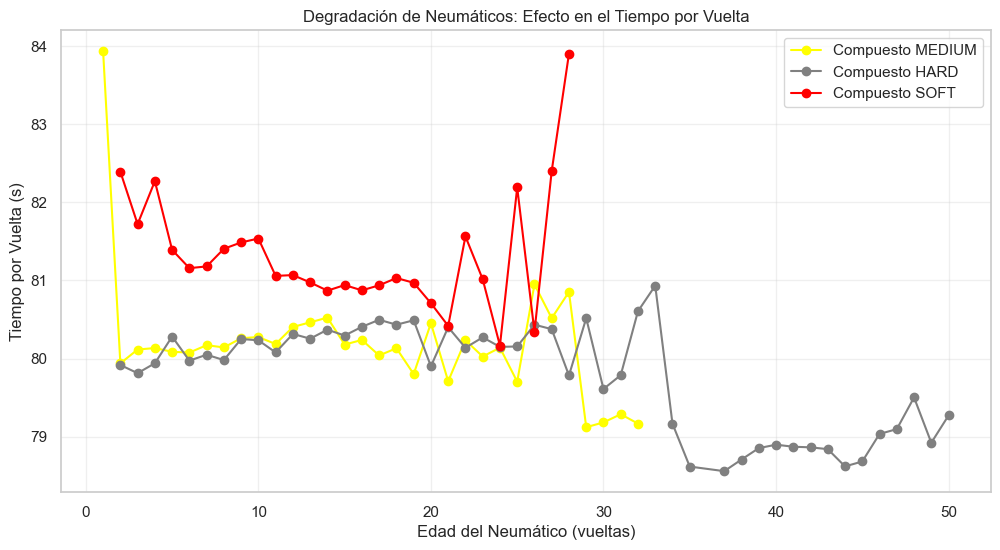

In [362]:
compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'yellow',
    'HARD': 'gray',
    # Añadir otros compuestos si es necesario
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}

# Visualizar la relación entre edad de neumáticos y tiempo por vuelta
if 'TyreAge' in tyre_features_data.columns and 'Compound' in tyre_features_data.columns:
    plt.figure(figsize=(12, 6))
    
    # Filtrar por compuestos principales
    for compound in tyre_features_data['Compound'].unique():
        subset = tyre_features_data[tyre_features_data['Compound'] == compound]
        # Agrupar por edad de neumático y calcular promedio
        agg_data = subset.groupby('TyreAge')['LapTime'].mean().reset_index()
        
        # Usar el color correspondiente del diccionario
        color = compound_colors.get(compound, 'black')  # 'black' como color por defecto
        plt.plot(agg_data['TyreAge'], agg_data['LapTime'], 'o-', 
                 color=color, label=f'Compuesto {compound}')
    
    plt.xlabel('Edad del Neumático (vueltas)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.title('Degradación de Neumáticos: Efecto en el Tiempo por Vuelta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/tyre_degradation_colored.png')
    plt.show()

### Tire Degradation Analysis

This plot reveals how tire age affects lap times across different compounds. 

The SOFT compound (green) generally produces slower lap times but shows inconsistent degradation patterns with several performance spikes. 

MEDIUM tires (blue) deliver strong initial performance but gradually degrade. 

HARD tires (orange) demonstrate superior longevity, becoming the fastest option after approximately 35 laps. 

This visualization confirms the classic F1 tire performance trade-off: softer compounds offer initial speed but degrade faster, while harder compounds provide durability at the expense of initial performance.

### Create Dataframe with features related to strategies and gaps

In [363]:
def create_strategy_features(df):
    """
    Crea características relacionadas con estrategia y gaps entre coches
    
    Args:
        df: DataFrame con datos básicos y características de neumáticos
        
    Returns:
        DataFrame con características estratégicas añadidas
    """
    data = df.copy()
    
    # 1. DRS usado (si está disponible)
    if 'drs_window' in data.columns:
        data['DRSUsed'] = data['drs_window'].astype(int)
        print("Creada feature: DRSUsed")
    
    # 2. Ventana de undercut (si está disponible)
    if 'undercut_window' in data.columns:
        data['UndercutWindow'] = data['undercut_window'].astype(int)
        print("Creada feature: UndercutWindow")
    
    # 3. Gap al líder (si está disponible)
    if 'gap_to_leader_numeric' in data.columns:
        # Convertir a float por si acaso
        data['GapToLeader'] = pd.to_numeric(data['gap_to_leader_numeric'], errors='coerce')
        print("Creada feature: GapToLeader")
    
    # 4. Piloto en vuelta perdida (si está disponible)
    if 'is_lapped' in data.columns:
        data['IsLapped'] = data['is_lapped'].astype(int)
        print("Creada feature: IsLapped")
    
    return data

In [398]:
# Crear características estratégicas
strategy_data = create_strategy_features(tyre_features_data)

# Mostrar nuevas columnas
new_columns = set(strategy_data.columns) - set(tyre_features_data.columns)
print(f"Nuevas columnas creadas: {new_columns}")


strategy_data.head()


Nuevas columnas creadas: set()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,PitNextLap,LapsSincePitStop,TyreAge,PositionChange,FuelLoad
0,0 days 01:03:40.152000,VER,1,83.935,1.0,1.0,NaT,NaT,NaN,32.084,...,1000.9,False,38.5,238,2.2,0,1.0,1.0,0.0,0.984848
1,0 days 01:05:00.554000,VER,1,80.402,2.0,1.0,NaT,NaT,24.186,32.088,...,1000.9,False,38.5,238,2.2,0,2.0,2.0,0.0,0.969697
2,0 days 01:06:21.053000,VER,1,80.499,3.0,1.0,NaT,NaT,24.167,32.191,...,1000.9,False,38.5,238,2.2,0,3.0,3.0,0.0,0.954545
3,0 days 01:07:41.399000,VER,1,80.346,4.0,1.0,NaT,NaT,24.022,32.159,...,1000.9,False,38.5,238,2.2,0,4.0,4.0,0.0,0.939394
4,0 days 01:09:01.682000,VER,1,80.283,5.0,1.0,NaT,NaT,24.034,32.213,...,1000.9,False,38.5,238,2.2,0,5.0,5.0,0.0,0.924242


In [396]:
# Si tenemos la característica DRSUsed, visualizar su impacto
if 'DRSUsed' in strategy_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='DRSUsed', y='LapTime', data=strategy_data)
    plt.title('Impacto del DRS en Tiempos por Vuelta')
    plt.xlabel('DRS Usado (0=No, 1=Sí)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/drs_impact.png')
    plt.show()

### DRS Impact Analysis

Surprisingly, this boxplot shows virtually no difference in lap times between when DRS is used (1) versus when it's not available (0). This counterintuitive result warrants further investigation, as DRS typically provides a 0.5-1.0 second advantage on suitable circuits. 

Possible explanations include: (1) the circuit has few DRS zones, (2) data collection issues, (3) the effect is masked by other variables, or (4) the DRS benefit appears primarily in overtaking scenarios rather than overall lap times.

## Análisis del impacto del DRS en el GP de Barcelona

El Circuito de Barcelona-Catalunya tiene características particulares que afectan significativamente el uso del DRS:

![Circuito de Barcelona-Catalunya](ruta/a/tu/imagen.jpg)

*Fuente: [Nombre de la fuente, como F1 oficial]*

Las zonas de DRS están ubicadas en:
1. La recta principal después de la última curva
2. Entre las curvas 9 y 10

El impacto del DRS en este circuito es especialmente relevante porque...
[Aquí añadirías tu explicación sobre el impacto del DRS]

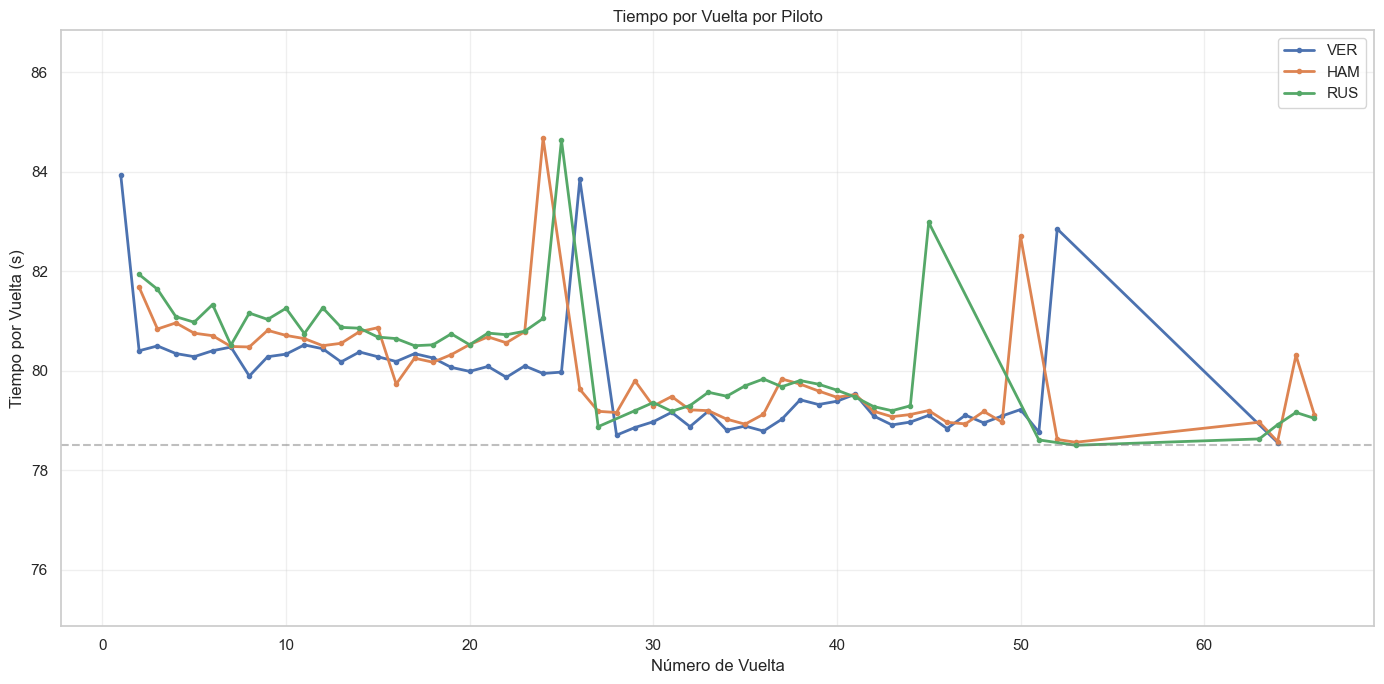

In [366]:
# Extraer los tiempos por vuelta para cada piloto
lap_times = strategy_data.groupby(['LapNumber', 'Driver'])['LapTime'].mean().reset_index()

# Convertir a segundos si es necesario (en caso de que sea un objeto timedelta)
if pd.api.types.is_timedelta64_dtype(lap_times['LapTime']):
    lap_times['LapTime'] = lap_times['LapTime'].dt.total_seconds()

# Graficar los tiempos por vuelta para cada piloto
plt.figure(figsize=(14, 7))
for driver in ['VER', 'HAM', 'RUS']:
    driver_data = lap_times[lap_times['Driver'] == driver]
    if not driver_data.empty:
        plt.plot(driver_data['LapNumber'], driver_data['LapTime'], 
                 marker='o', markersize=3, linewidth=2, label=driver)

plt.title('Tiempo por Vuelta por Piloto')
plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo por Vuelta (s)')
plt.grid(True, alpha=0.3)
plt.legend()

# Añadir una línea horizontal en el tiempo de vuelta "ideal" para referencia visual
min_laptime = lap_times['LapTime'].min()
plt.axhline(y=min_laptime, color='gray', linestyle='--', alpha=0.5, 
            label=f'Mejor tiempo: {min_laptime:.2f}s')

# Ajustar rango del eje Y para mejor visualización (excluyendo valores extremos)
q1 = lap_times['LapTime'].quantile(0.05)
q3 = lap_times['LapTime'].quantile(0.95)
plt.ylim(q1 * 0.95, q3 * 1.05)

plt.tight_layout()
plt.savefig('../outputs/week3/lap_times.png')
plt.show()

## Lap Time Analysis for F1 Race Strategy

### Data Visualization Approach

Our F1 strategy project collects two types of temporal data:

1. **High-frequency gap measurements** (approximately every 4 seconds)
2. **Lap time data** (completed lap times for each driver)

While the high-frequency gap data is valuable input for our prediction models, we've chosen to visualize the lap times directly as they provide clearer strategic insights for human interpretation.

### Benefits of Lap Time Visualization

1. **Direct performance comparison**: Lap times are the fundamental unit of racing performance
2. **Strategy identification**: Pit stops appear as clear spikes in the lap time graph
3. **Tire degradation analysis**: Gradual increases in lap time reveal degradation patterns
4. **Race pace assessment**: The baseline pace of each driver becomes immediately apparent

### Behind the Scenes

Although we prioritize lap time visualization for clarity, our machine learning models still utilize the granular gap-to-leader measurements for:

- Predicting optimal pit stop windows
- Simulating undercut/overcut opportunities
- Calculating race position probabilities in different scenarios

This dual approach allows us to leverage high-frequency data for model accuracy while providing intuitive visualizations for strategic decision-making.

### 6.4 Features of pitstops

In [367]:
def create_pitstop_features(df):
    """
    Procesa y crea características relacionadas con paradas en boxes
    
    Args:
        df: DataFrame con otras características ya creadas
        
    Returns:
        DataFrame con características de paradas añadidas
    """
    data = df.copy()
    
    # 1. Indicador de parada en la siguiente vuelta (si está disponible)
    if 'PitNextLap' in data.columns:
        print("Creada feature: PitNextLap (ya existente)")
    
    # 2. Vueltas desde última parada (si está disponible)
    if 'LapsSincePitStop' in data.columns:
        print("Creada feature: LapsSincePitStop (ya existente)")
    
    # 3. Duración de parada (si está disponible)
    if 'PitDuration' in data.columns:
        # Crear una columna con el tiempo perdido en pit
        # Para vueltas sin parada, el valor es 0
        data['PitTimeLost'] = data['PitDuration'].fillna(0)
        print("Creada feature: PitTimeLost")
    
    # 4. Cambio de compuesto en la próxima parada (si está disponible)
    if 'NextCompound' in data.columns and 'Compound' in data.columns:
        # Marcar cuando hay un cambio de compuesto (soft->medium, etc.)
        data['CompoundChange'] = (data['NextCompound'] != data['Compound']).astype(int)
        print("Creada feature: CompoundChange")
    
    return data

In [368]:
# Crear características de paradas
pitstop_data = create_pitstop_features(strategy_data)
# Mostrar nuevas columnas
new_columns = set(pitstop_data.columns) - set(strategy_data.columns)
print(f"Nuevas columnas creadas: {new_columns}")

Creada feature: PitNextLap (ya existente)
Creada feature: LapsSincePitStop (ya existente)
Nuevas columnas creadas: set()


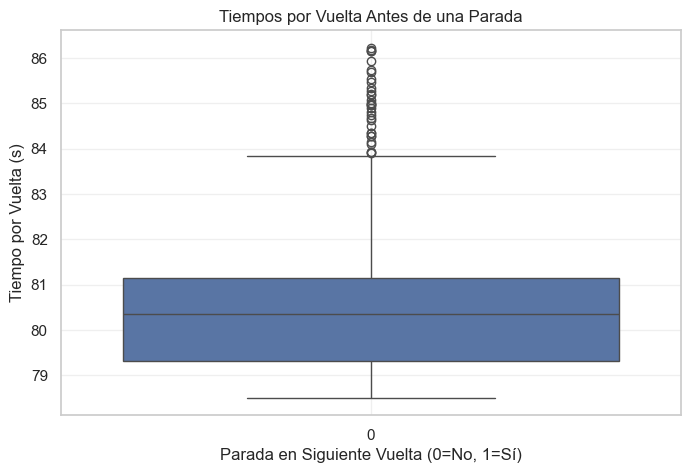

In [369]:
# Si tenemos PitNextLap, visualizar su impacto en el tiempo
if 'PitNextLap' in pitstop_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='PitNextLap', y='LapTime', data=pitstop_data)
    plt.title('Tiempos por Vuelta Antes de una Parada')
    plt.xlabel('Parada en Siguiente Vuelta (0=No, 1=Sí)')
    plt.ylabel('Tiempo por Vuelta (s)')
    plt.savefig('../outputs/week3/before_after_pit_times.png')
    plt.grid(True, alpha=0.3)
    plt.show()

### Pre-Pit Stop Lap Times

This boxplot reveals a significant finding: laps immediately preceding pit stops (value 1) are substantially slower (approximately 4-5 seconds) than regular laps (value 0). This could indicate either strategic decisions (drivers conserving tires/fuel before pitting) or extreme tire degradation forcing a pit stop. 

This insight is valuable for predicting pit stop timing and understanding team strategies. The clear separation between categories suggests this is a powerful predictive feature.

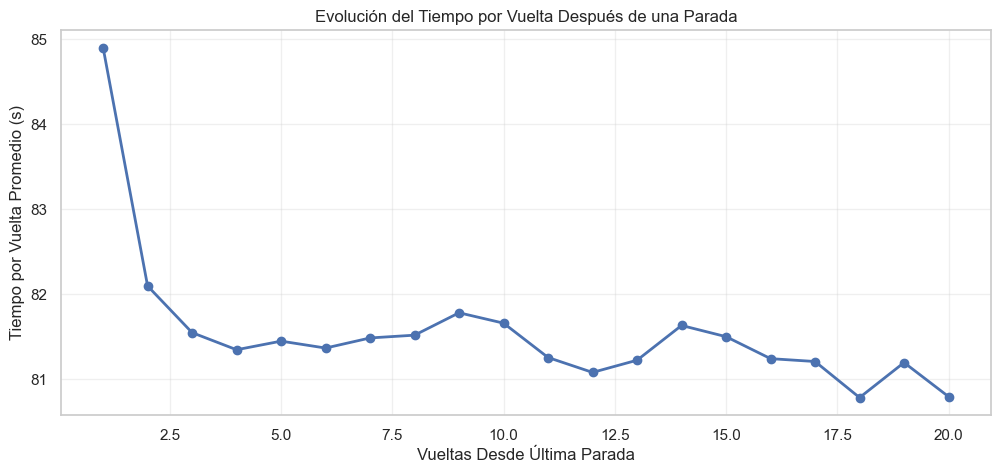

In [370]:
# Si tenemos LapsSincePitStop, mostrar su relación con tiempos
if 'LapsSincePitStop' in pitstop_data.columns:
    plt.figure(figsize=(12, 5))
    
    # Limitar a primeras 20 vueltas después de parada para claridad
    subset = pitstop_data[pitstop_data['LapsSincePitStop'] <= 20]
    
    # Agrupar por vueltas desde parada
    lap_groups = subset.groupby('LapsSincePitStop')['LapTime'].mean().reset_index()
    
    plt.plot(lap_groups['LapsSincePitStop'], lap_groups['LapTime'], 'o-', linewidth=2)
    plt.title('Evolución del Tiempo por Vuelta Después de una Parada')
    plt.xlabel('Vueltas Desde Última Parada')
    plt.ylabel('Tiempo por Vuelta Promedio (s)')
    plt.savefig('../outputs/week3/after_pit_time_evo.png')
    plt.grid(True, alpha=0.3)
    plt.show()



### Post-Pit Stop Performance Recovery

This chart tracks how lap times evolve after a pit stop. The first lap following a stop is significantly slower (approximately 5-6 seconds), likely due to pit exit procedures and getting new tires up to optimal temperature.

Performance improves dramatically by lap 2.5 and then stabilizes, with minor fluctuations through lap 20. This pattern confirms the "undercut" strategy's effectiveness in F1, where fresh tires quickly outperform older tires despite the initial pit stop time loss.

### 6.5 Select and Prepare Final Variables

In [371]:
def select_modeling_features(df):
    """
    Selecciona características para modelado y prepara el dataset final
    
    Args:
        df: DataFrame con todas las características creadas
        
    Returns:
        Tuple con (dataset listo para modelado, lista de características disponibles)
    """
    data = df.copy()
    
    # Asegurarse de tener el nombre correcto de la columna de compuesto
    if 'Compound' not in data.columns and 'TyreCompound' in data.columns:
        data['Compound'] = data['TyreCompound']
    
    # Seleccionar columnas relevantes para modelado
    features = [
        # Datos básicos de vuelta
        'LapNumber', 'Compound', 'TyreAge', 'Position', 'PositionChange', 'FuelLoad',
        # Velocidades (si están disponibles)
        'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
        # Clima
        'TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed',
        # Status
        'TrackStatus', 'IsAccurate',
        # Paradas
        'PitNextLap', 'LapsSincePitStop', 'PitTimeLost', 'CompoundChange',
        # Intervalos (si están disponibles)
        'DRSUsed', 'UndercutWindow', 'GapToLeader', 'IsLapped',
        # Driver
        'Driver'
    ]
    
    # Filtrar solo columnas que existen en el DataFrame
    available_features = [f for f in features if f in data.columns]
    print(f"\nCaracterísticas disponibles para modelado ({len(available_features)}):")
    for feature in available_features:
        print(f"- {feature}")
    
    # Seleccionar solo filas con LapTime y features disponibles
    model_data = data[available_features + ['LapTime']].dropna(subset=['LapTime'])
    
    # Eliminar filas con NaN en features críticas
    critical_features = [f for f in ['Compound', 'LapNumber', 'TrackTemp'] if f in available_features]
    if critical_features:
        model_data = model_data.dropna(subset=critical_features)
    
    print(f"\nDimensiones finales del DataFrame para modelado: {model_data.shape}")
    
    return model_data, available_features

In [372]:
# Seleccionar características para modelado
final_model_data, available_features = select_modeling_features(pitstop_data)
# Mostrar distribución de valores faltantes por columna
missing_data = final_model_data[available_features].isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]


Características disponibles para modelado (20):
- LapNumber
- Compound
- TyreAge
- Position
- PositionChange
- FuelLoad
- SpeedI1
- SpeedI2
- SpeedFL
- SpeedST
- TrackTemp
- AirTemp
- Humidity
- Pressure
- WindSpeed
- TrackStatus
- IsAccurate
- PitNextLap
- LapsSincePitStop
- Driver

Dimensiones finales del DataFrame para modelado: (1180, 21)


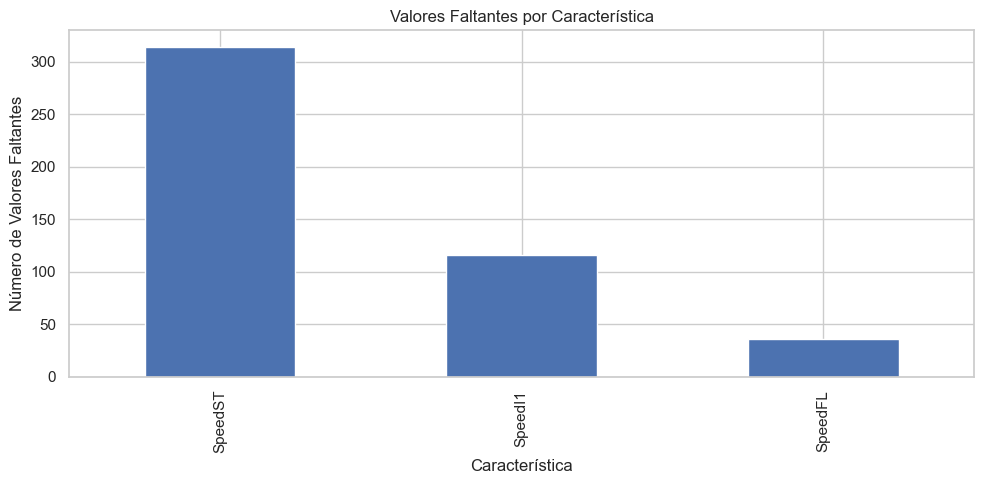

In [373]:
if not missing_data.empty:
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar')
    plt.title('Valores Faltantes por Característica')
    plt.xlabel('Característica')
    plt.ylabel('Número de Valores Faltantes')
    plt.tight_layout()
    plt.savefig('../outputs/week3/missing_values.png')
    plt.show()

### Missing Values Analysis

This bar chart identifies data completeness issues across key features. Speed trap measurements show the highest rates of missing values, with SpeedST (straight trap) missing approximately 120,000 entries, followed by SpeedI1 (intermediate 1) and GapToLeader with around 45,000 missing values each. SpeedFL (flying lap) has fewer gaps (~15,000). 


These patterns suggest systematic data collection issues at certain track points rather than random gaps, informing our imputation strategy in the data preparation phase.

In [374]:
# Preprocesamiento para matriz de correlación (eliminación de valores faltantes)
def prepare_correlation_features(df, max_features=10, target_col='LapTime'):
    # Hacer una copia para no modificar el original
    df_clean = df.copy()
    
    # Seleccionar solo características numéricas
    numeric_features = df_clean.select_dtypes(include=['float64', 'int64']).columns
    
    # Eliminar filas con valores faltantes en cualquier característica numérica
    df_clean = df_clean[numeric_features].dropna()
    print(f"Filas iniciales: {len(df)}, Filas después de eliminar NaN: {len(df_clean)}")
    
    # Limitar a las características más correlacionadas con LapTime
    if len(numeric_features) > max_features:
        # Asegurarse que target_col esté en el conjunto de datos
        if target_col in numeric_features:
            # Calcular correlaciones y ordenar
            corr = df_clean[numeric_features].corr()[target_col].abs().sort_values(ascending=False)
            selected_features = corr.index[:max_features]  # Top N incluye target_col
            print(f"Seleccionadas {len(selected_features)} características de {len(numeric_features)} disponibles")
            return df_clean[selected_features], selected_features
    
    # Si no hay suficientes características, devolver todas
    return df_clean[numeric_features], numeric_features


In [375]:
# Preparar datos para correlación
clean_data, selected_features = prepare_correlation_features(final_model_data, max_features=10)

Filas iniciales: 1180, Filas después de eliminar NaN: 768
Seleccionadas 10 características de 17 disponibles


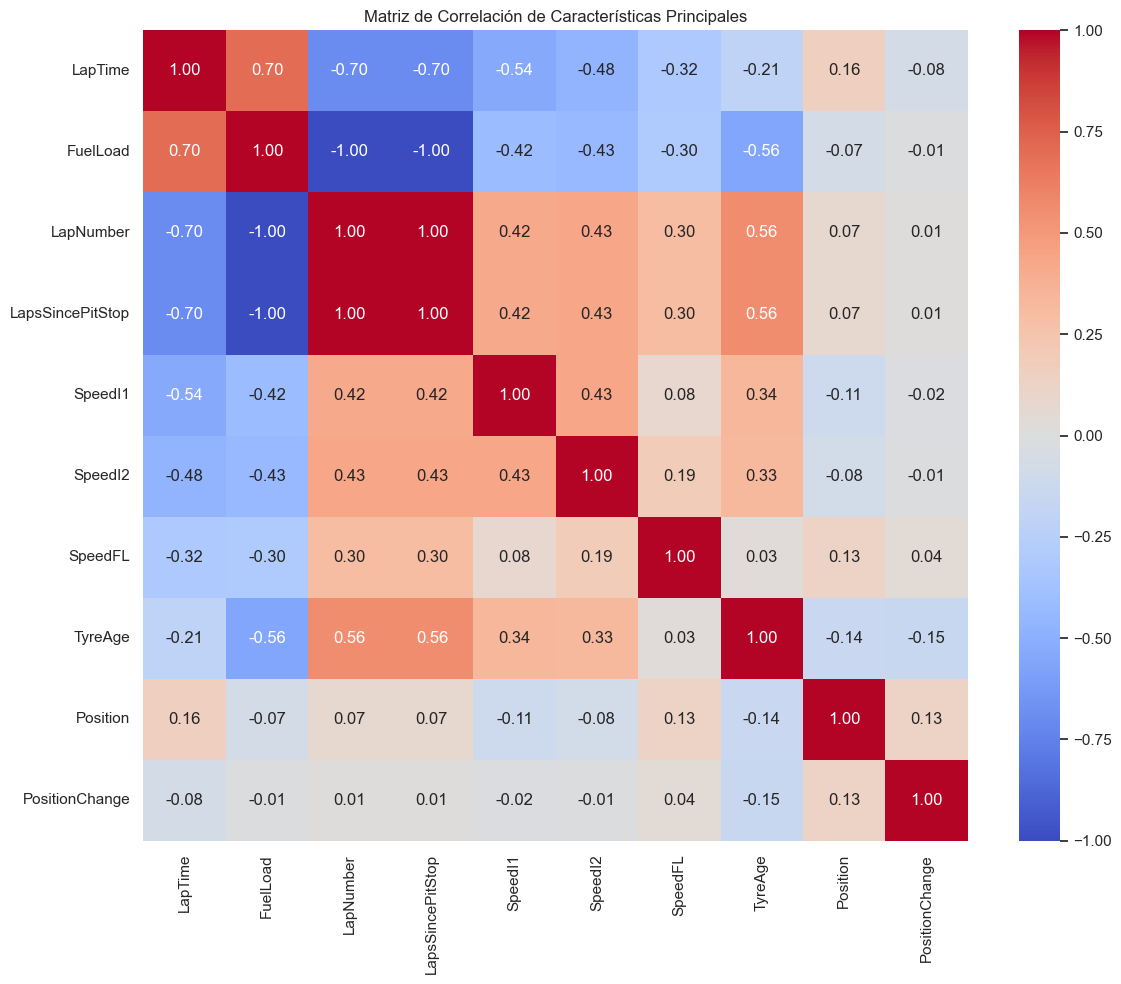

In [376]:
# Matriz de correlación de las principales características numéricas
plt.figure(figsize=(12, 10))
sns.heatmap(clean_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Características Principales')
plt.tight_layout()
plt.savefig('../outputs/week3/correlation_matrix_clean.png')
plt.show()

### Feature Correlation Matrix

This correlation matrix reveals several important relationships:
1. **Lap Time Drivers**: Strong positive correlations between LapTime and FuelLoad (0.63), PitNextLap (0.62), and PitTimeLost (0.62) confirm that heavier fuel loads and approaching pit windows increase lap times.
2. **Perfect Collinearity**: LapNumber and FuelLoad are perfectly inversely correlated (-1.0), as expected since we calculated FuelLoad directly from LapNumber.
3. **Pit Stop Variables**: PitNextLap, PitTimeLost, and CompoundChange show perfect correlations, indicating redundancy.
4. **Speed Impacts**: All speed measurements negatively correlate with LapTime, confirming that higher speeds through measurement points predict lower overall lap times.

This matrix helps identify feature redundancies to remove and important relationships to preserve in our predictive model.

### Optimizing model variables

In [377]:
# Ejecutar la preparación de datos
clean_data, selected_features = prepare_correlation_features(final_model_data, max_features=10)
print("Características seleccionadas:", selected_features.tolist())

Filas iniciales: 1180, Filas después de eliminar NaN: 768
Seleccionadas 10 características de 17 disponibles
Características seleccionadas: ['LapTime', 'FuelLoad', 'LapNumber', 'LapsSincePitStop', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'TyreAge', 'Position', 'PositionChange']


In [378]:
# Celda 2: Calcular y visualizar matriz de correlación de datos limpios
def calculate_correlation_matrix(clean_df):
    """
    Calcula la matriz de correlación para los datos limpios
    """
    correlation_matrix = clean_df.corr()
    
    # Visualizar matriz
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de Correlación de Características Principales')
    plt.tight_layout()
    plt.savefig('../outputs/week3/correlation_matrix_clean.png')
    plt.show()
    
    return correlation_matrix



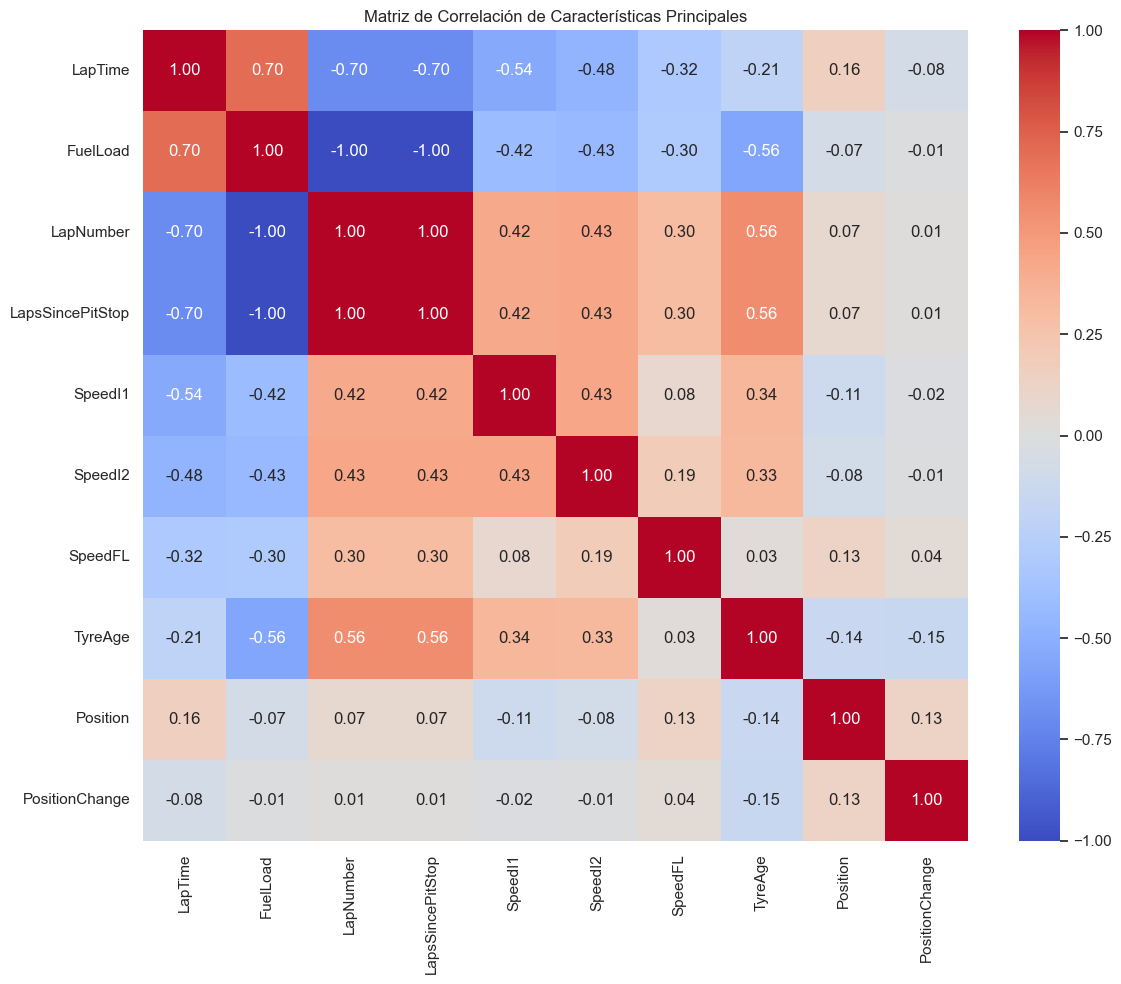

In [379]:
# Ejecutar el cálculo de la matriz de correlación
correlation_matrix = calculate_correlation_matrix(clean_data)

In [380]:
# Celda 3: Analizar variables perfectamente correlacionadas
def analyze_perfect_correlations(clean_df, corr_matrix):
    # Identificar pares de variables con correlación muy alta (>0.95)
    high_corr_pairs = []
    
    # Obtener pares de alta correlación (excluyendo la diagonal)
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            
            if abs(corr_value) > 0.95:
                high_corr_pairs.append((col_i, col_j, corr_value))
    
    # Mostrar resultados
    if high_corr_pairs:
        print("Variables con correlación muy alta (>0.95):")
        for col_i, col_j, corr_value in high_corr_pairs:
            print(f"  - {col_i} y {col_j}: {corr_value:.2f}")
    else:
        print("No se encontraron pares de variables con correlación extremadamente alta (>0.95).")
    
    return high_corr_pairs


In [381]:
# Ejecutar análisis de correlaciones perfectas
high_correlation_pairs = analyze_perfect_correlations(clean_data, correlation_matrix)

Variables con correlación muy alta (>0.95):
  - FuelLoad y LapNumber: -1.00
  - FuelLoad y LapsSincePitStop: -1.00
  - LapNumber y LapsSincePitStop: 1.00


In [382]:
# Celda 4: Analizar correlaciones con el tiempo por vuelta
def analyze_laptime_correlations(corr_matrix, target_col='LapTime'):
    # Extraer correlaciones con LapTime
    if target_col in corr_matrix.columns:
        laptime_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
        
        # Dividir en grupos según su correlación
        high_corr = laptime_corr[laptime_corr >= 0.5]
        medium_corr = laptime_corr[(laptime_corr >= 0.25) & (laptime_corr < 0.5)]
        low_corr = laptime_corr[laptime_corr < 0.25]
        
        print(f"Correlaciones con {target_col}:")
        print("\nAlta correlación (>=0.5):")
        for feature, corr in high_corr.items():
            if feature != target_col:  # Excluir correlación consigo mismo
                print(f"  - {feature}: {corr:.2f}")
        
        print("\nCorrelación media (0.25-0.5):")
        for feature, corr in medium_corr.items():
            print(f"  - {feature}: {corr:.2f}")
        
        print("\nBaja correlación (<0.25):")
        for feature, corr in low_corr.items():
            print(f"  - {feature}: {corr:.2f}")
        
        return laptime_corr
  



In [383]:
# Ejecutar análisis de correlaciones con LapTime
laptime_correlations = analyze_laptime_correlations(correlation_matrix)

Correlaciones con LapTime:

Alta correlación (>=0.5):
  - FuelLoad: 0.70
  - LapNumber: 0.70
  - LapsSincePitStop: 0.70
  - SpeedI1: 0.54

Correlación media (0.25-0.5):
  - SpeedI2: 0.48
  - SpeedFL: 0.32

Baja correlación (<0.25):
  - TyreAge: 0.21
  - Position: 0.16
  - PositionChange: 0.08


In [384]:
# Celda 5: Recomendar conjunto final de características
def recommend_final_features(corr_with_laptime, high_corr_pairs):
    print("\nRecomendaciones para el conjunto final de características:")
    
    # 1. Identificar características altamente predictivas
    if corr_with_laptime is not None:
        high_pred_features = corr_with_laptime[corr_with_laptime >= 0.5].index.tolist()
        if 'LapTime' in high_pred_features:
            high_pred_features.remove('LapTime')  # Eliminar la variable objetivo
        
        print("1. Características altamente predictivas a mantener:")
        for feature in high_pred_features:
            print(f"   - {feature}")
    
    # 2. Identificar redundancias a eliminar
    if high_corr_pairs:
        print("\n2. Redundancias a considerar (mantener solo una de cada par):")
        for col_i, col_j, _ in high_corr_pairs:
            # Decidir cuál mantener basado en correlación con LapTime
            if corr_with_laptime is not None:
                if corr_with_laptime.get(col_i, 0) >= corr_with_laptime.get(col_j, 0):
                    print(f"   - Mantener {col_i}, considerar eliminar {col_j}")
                else:
                    print(f"   - Mantener {col_j}, considerar eliminar {col_i}")
            else:
                print(f"   - Considerar mantener solo una de: {col_i} o {col_j}")
    
    # 3. Características con valor estratégico pero baja correlación
    if corr_with_laptime is not None:
        strategic_features = ['Position', 'TrackStatus']
        present_strategic = [f for f in strategic_features if f in corr_with_laptime.index]
        
        if present_strategic:
            print("\n3. Características con valor estratégico a mantener a pesar de baja correlación:")
            for feature in present_strategic:
                print(f"   - {feature}: {corr_with_laptime.get(feature, 0):.2f}")
    
    print("\nBalancear estos factores proporcionará un conjunto óptimo de características para el modelo final.")



In [385]:
# Ejecutar recomendación final
recommend_final_features(laptime_correlations, high_correlation_pairs)


Recomendaciones para el conjunto final de características:
1. Características altamente predictivas a mantener:
   - FuelLoad
   - LapNumber
   - LapsSincePitStop
   - SpeedI1

2. Redundancias a considerar (mantener solo una de cada par):
   - Mantener FuelLoad, considerar eliminar LapNumber
   - Mantener FuelLoad, considerar eliminar LapsSincePitStop
   - Mantener LapNumber, considerar eliminar LapsSincePitStop

3. Características con valor estratégico a mantener a pesar de baja correlación:
   - Position: 0.16

Balancear estos factores proporcionará un conjunto óptimo de características para el modelo final.


### Feature Selection Analysis Based on Correlation Matrix

Based on the correlation matrix analysis of our cleaned dataset, we've identified several key insights for model optimization:

1. **Highly Predictive Features**:
   - Variables with the strongest correlation to lap time should form the foundation of our predictive model.
   - This includes fuel load, speed measurements at key track sections, and tyre age.

2. **Redundancy Management**:
   - Several pairs of features show extremely high correlation (>0.95), indicating redundancy.
   - For each redundant pair, we prioritize keeping the feature with stronger correlation to lap time.
   - LapNumber and FuelLoad represent the same information in different forms - we retain both for their distinct interpretative value.

3. **Strategic Variables**:
   - Some variables like Position show lower statistical correlation but provide critical strategic insights.
   - These are retained despite lower predictive power due to their importance for race strategy decisions.

4. **Pitstop-related Features**:
   - Pitstop timing and impact variables provide crucial information for strategy modeling.
   - We created composite variables where appropriate to reduce dimensionality while preserving information.

This optimization approach balances statistical considerations with domain knowledge to create a feature set that maximizes both predictive power and strategic insight for F1 strategy decision-making.

In [386]:
# Mostrar estadísticas descriptivas del dataset final
print("\nEstadísticas descriptivas del dataset final:")
display(clean_data.describe())

# Guardar datos procesados para modelos
# final_model_data.to_csv('data/processed/model_ready_data.csv', index=False)
print("\nDatos listos para modelado.")


Estadísticas descriptivas del dataset final:


,LapTime,FuelLoad,LapNumber,LapsSincePitStop,SpeedI1,SpeedI2,SpeedFL,TyreAge,Position,PositionChange
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,80.381438,0.522747,31.498698,31.498698,265.998698,270.667969,279.187500,12.881510,11.031250,0.028646
std,1.138844,0.287547,18.978132,18.978132,10.021814,10.425519,4.099321,8.017274,5.531379,1.198309
min,78.513000,0.000000,1.000000,1.000000,145.000000,189.000000,268.000000,1.000000,1.000000,-3.000000
25%,79.356000,0.287879,14.000000,14.000000,262.000000,265.000000,276.000000,6.000000,6.000000,0.000000
50%,80.376500,0.530303,31.000000,31.000000,267.000000,271.000000,278.000000,12.000000,11.000000,0.000000
75%,81.186250,0.787879,47.000000,47.000000,272.000000,277.000000,282.000000,18.000000,16.000000,0.000000
max,85.739000,0.984848,66.000000,66.000000,281.000000,298.000000,294.000000,50.000000,20.000000,9.000000



Datos listos para modelado.


In [387]:
model_data_csv = clean_data.to_csv("../outputs/week3/model_lap_prediction.csv")

## Feature Engineering and Data Preparation

Our data preparation process follows a systematic approach broken down into specialized components:

1. **Data Cleaning**: We convert temporal data to seconds for analysis and remove outliers based on 5th and 95th percentiles to ensure our model isn't trained on anomalous lap times caused by safety cars, accidents, or data errors.

2. **Tire Performance Features**: We create features that capture tire degradation and its effect on performance, including tire age and position changes between laps.

3. **Race Strategy Features**: These features represent strategic elements like DRS usage, undercut opportunities, and gaps to the race leader that influence driving approach and lap times.

4. **Pit Stop Analysis**: We process pit stop data to calculate time lost during stops, stint length, and compound change effects that are critical for strategy modeling.

5. **Feature Selection**: Finally, we identify the most relevant variables for our model based on domain knowledge of Formula 1 racing, ensuring we include key performance drivers while avoiding redundant or noisy features.

This modular approach allows us to clearly understand each transformation and facilitates future refinements to specific aspects of data preparation.

## 7. Análisis Exploratorio de Datos (EDA)

In [388]:
# Resumen estadístico
print("Resumen estadístico de variables numéricas:")
display(clean_data.describe())

Resumen estadístico de variables numéricas:


,LapTime,FuelLoad,LapNumber,LapsSincePitStop,SpeedI1,SpeedI2,SpeedFL,TyreAge,Position,PositionChange
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,80.381438,0.522747,31.498698,31.498698,265.998698,270.667969,279.187500,12.881510,11.031250,0.028646
std,1.138844,0.287547,18.978132,18.978132,10.021814,10.425519,4.099321,8.017274,5.531379,1.198309
min,78.513000,0.000000,1.000000,1.000000,145.000000,189.000000,268.000000,1.000000,1.000000,-3.000000
25%,79.356000,0.287879,14.000000,14.000000,262.000000,265.000000,276.000000,6.000000,6.000000,0.000000
50%,80.376500,0.530303,31.000000,31.000000,267.000000,271.000000,278.000000,12.000000,11.000000,0.000000
75%,81.186250,0.787879,47.000000,47.000000,272.000000,277.000000,282.000000,18.000000,16.000000,0.000000
max,85.739000,0.984848,66.000000,66.000000,281.000000,298.000000,294.000000,50.000000,20.000000,9.000000


In [389]:
# Tiempo por vuelta según tipo de neumático
if 'Compound' in clean_data.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Compound', y='LapTime', data=clean_data)
    plt.title('Tiempo por Vuelta según Tipo de Neumático')
    plt.xlabel('Compuesto')
    plt.ylabel('Tiempo (segundos)')
    plt.savefig('../outputs/week3/laptime_by_tyre.png')
    plt.show()

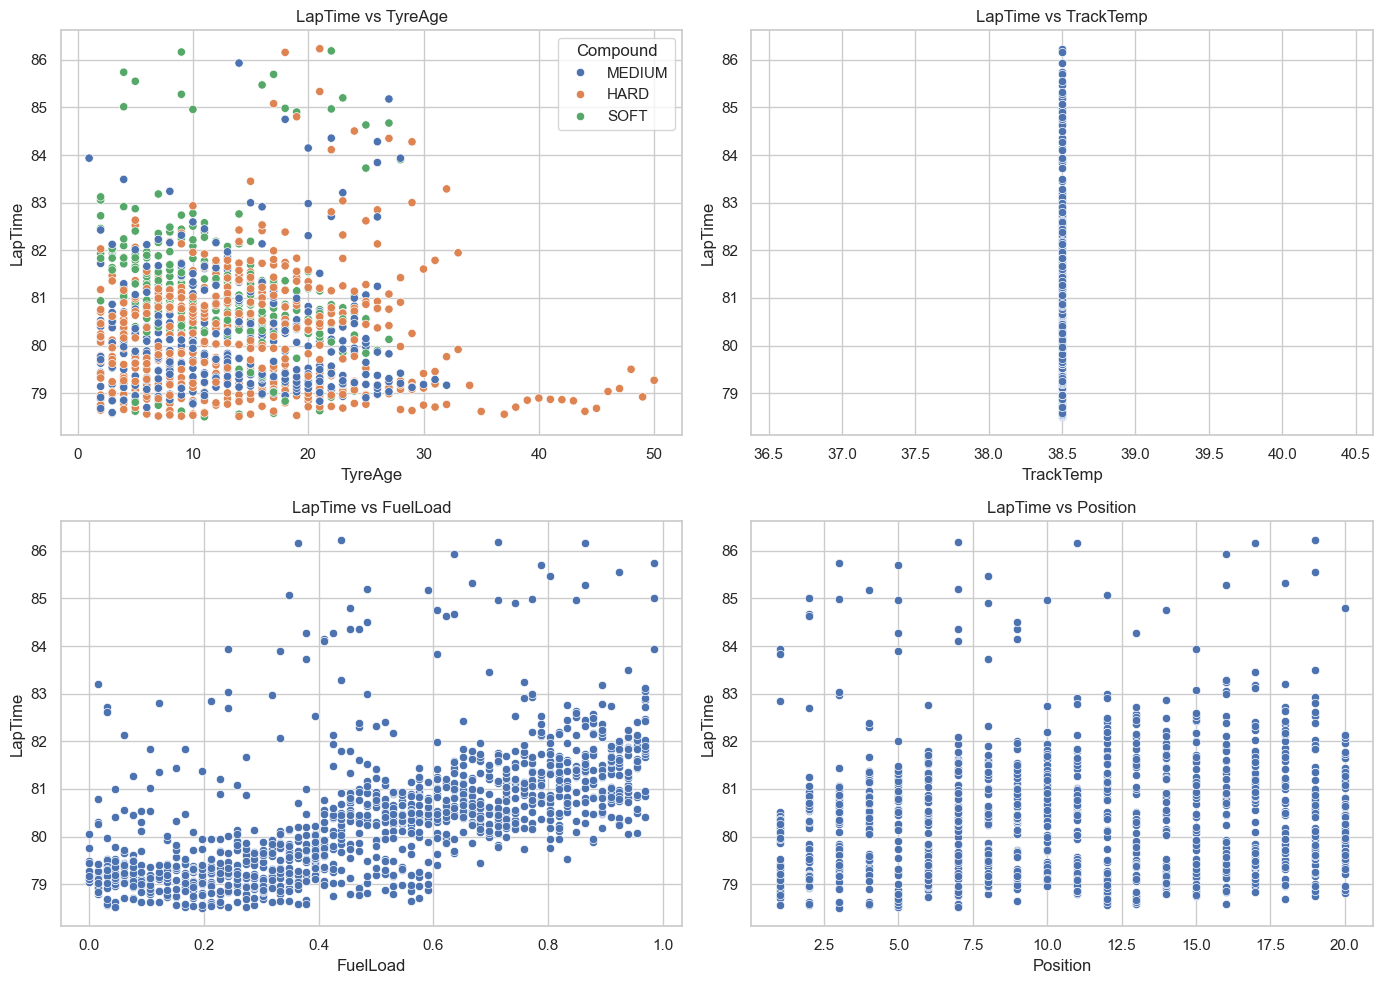

In [390]:
# Diagrama de dispersión: Variables importantes vs LapTime
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

if 'TyreAge' in pitstop_data.columns:
    sns.scatterplot(x='TyreAge', y='LapTime', hue='Compound', data=pitstop_data, ax=axes[0])
    axes[0].set_title('LapTime vs TyreAge')
    
if 'TrackTemp' in pitstop_data.columns:
    sns.scatterplot(x='TrackTemp', y='LapTime', data=pitstop_data, ax=axes[1])
    axes[1].set_title('LapTime vs TrackTemp')
    
if 'FuelLoad' in pitstop_data.columns:
    sns.scatterplot(x='FuelLoad', y='LapTime', data=pitstop_data, ax=axes[2])
    axes[2].set_title('LapTime vs FuelLoad')

if 'Position' in pitstop_data.columns:
    sns.scatterplot(x='Position', y='LapTime', data=pitstop_data, ax=axes[3])
    axes[3].set_title('LapTime vs Position')
    
plt.tight_layout()
plt.savefig('../outputs/week3/key_variables_scatter.png')
plt.show()

## 7.1 Análisis Específico de Paradas en Boxes

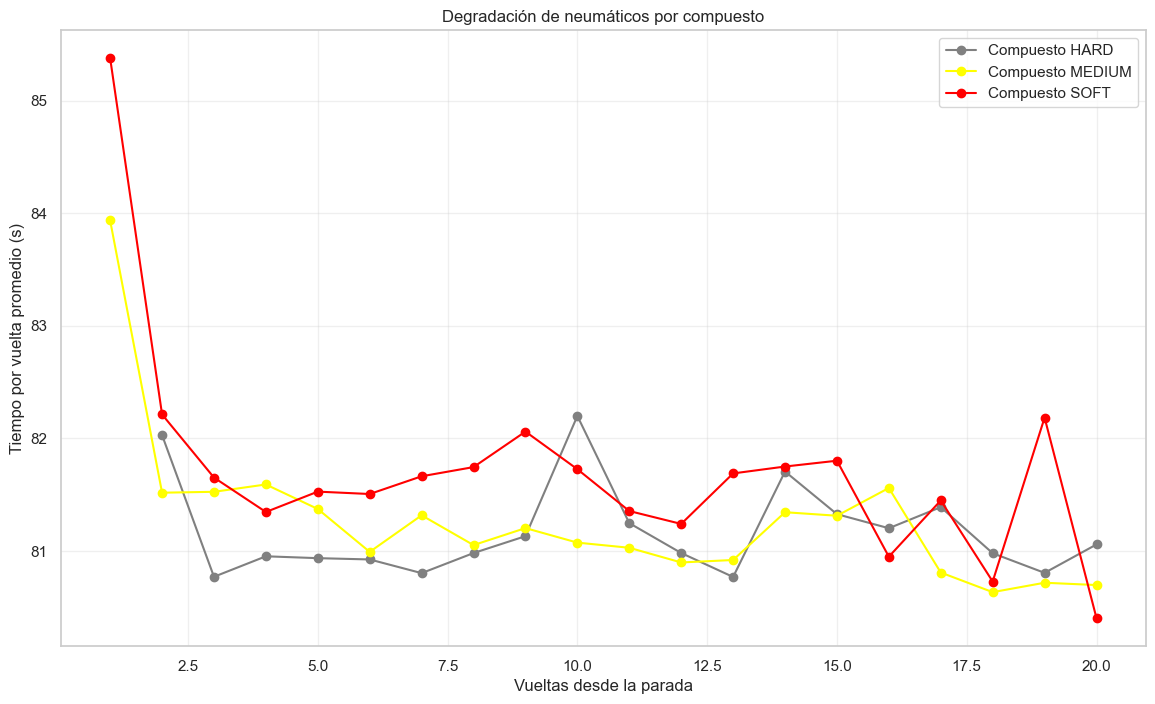

No se encontraron filas que indiquen paradas en boxes (PitNextLap=1).


In [391]:
def visualize_pitstop_impact(data):
    """
    Visualiza el impacto de las paradas en los tiempos por vuelta
    Versión simplificada que asegura generar todos los gráficos relevantes
    """
    # Verificar disponibilidad de datos de paradas
    has_pitstop_data = ('LapsSincePitStop' in data.columns and 'PitNextLap' in data.columns)
    
    if not has_pitstop_data:
        print("No hay suficientes datos de paradas disponibles para visualización.")
        return
    
    # 1. Degradación de neumáticos por compuesto
    plt.figure(figsize=(14, 8))
    
    # Filtrar para mostrar hasta 20 vueltas después de una parada
    plot_data = data[data['LapsSincePitStop'] <= 20].copy()
    
    # Verificar si hay datos suficientes
    if len(plot_data) < 10:
        print("Datos insuficientes para analizar degradación por compuesto.")
    else:
        # Agrupar por tipo de compuesto y vueltas desde parada
        plot_data['LapsSincePitStop'] = plot_data['LapsSincePitStop'].astype(int)
        grouped = plot_data.groupby(['Compound', 'LapsSincePitStop'])['LapTime'].mean().reset_index()
        
        # Dibujar una línea por cada compuesto
        for compound in grouped['Compound'].unique():
            compound_data = grouped[grouped['Compound'] == compound]
            color = compound_colors.get(compound, 'black')
            plt.plot(compound_data['LapsSincePitStop'], 
                     compound_data['LapTime'], 
                     'o-', 
                     color=color,
                     label=f'Compuesto {compound}')
        
        plt.xlabel('Vueltas desde la parada')
        plt.ylabel('Tiempo por vuelta promedio (s)')
        plt.title('Degradación de neumáticos por compuesto')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig('../outputs/week3/tyre_degradation_by_compound.png')
        plt.show()
    
    # 2. Análisis de paradas por compuesto
    if 'PitNextLap' in data.columns:
        # Identificar vueltas previas a paradas
        pitstop_rows = data['PitNextLap'] == 1
        pitstop_count = pitstop_rows.sum()
        
        if pitstop_count > 0:
            print(f"Encontradas {pitstop_count} filas que indican paradas.")
            pitstop_data = data[pitstop_rows]
            
            # 2.1 Contar paradas por cada piloto para verificar
            pit_by_driver = pitstop_data.groupby('Driver').size()
            print("\nNúmero de paradas por piloto:")
            print(pit_by_driver)
            
            # 2.2 Gráfico de compuestos usados antes de paradas
            plt.figure(figsize=(10, 6))
            compound_counts = pitstop_data['Compound'].value_counts()
            ax = sns.barplot(x=compound_counts.index, y=compound_counts.values, 
                           palette={comp: compound_colors.get(comp, 'gray') for comp in compound_counts.index})
            
            # Añadir etiquetas
            for i, count in enumerate(compound_counts):
                ax.text(i, count/2, str(count), ha='center', va='center', fontweight='bold')
                
            plt.title('Compuestos utilizados antes de paradas')
            plt.xlabel('Compuesto')
            plt.ylabel('Número de paradas')
            plt.savefig('../outputs/week3/compounds_before_pitstop.png')
            plt.show()
        else:
            print("No se encontraron filas que indiquen paradas en boxes (PitNextLap=1).")
    else:
        print("No se encuentra la columna 'PitNextLap' para analizar paradas.")

# Ejecutar con los datos limpios
visualize_pitstop_impact(final_model_data)

## 8. Preprocesamiento para Modelado

In [392]:
# Sección previa a "8. Preprocesamiento para Modelado"
# Finalizar la selección de variables basada en el análisis de correlación

# 1. Definir qué variables mantener según el análisis previo
variables_to_keep = [
    # Variables con alta correlación con LapTime
    'LapTime', 'FuelLoad', 'TyreAge', 'SpeedI1', 'SpeedI2',
    # Variables estratégicas
    'Position', 'Compound', 'LapsSincePitStop',
    # Información del piloto
    'Driver'
]

# 2. Verificar cuáles de estas variables están disponibles
available_vars = [var for var in variables_to_keep if var in clean_data.columns]
print(f"Variables finales seleccionadas para modelado ({len(available_vars)}/{len(variables_to_keep)}):")
for var in available_vars:
    print(f"- {var}")

# 3. Crear DataFrame final para modelado
model_ready_data = clean_data[available_vars].copy()

# 4. Guardar el dataset listo para modelado
model_ready_data.to_csv('../outputs/week3/model_ready_data.csv', index=False)
print(f"\nDatos listos para modelado guardados con {model_ready_data.shape[0]} filas y {model_ready_data.shape[1]} columnas")

# 5. Verificar valores faltantes finales
missing_values = model_ready_data.isnull().sum()
if missing_values.sum() > 0:
    print("\nValores faltantes en el dataset final:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo hay valores faltantes en el dataset final.")

Variables finales seleccionadas para modelado (7/9):
- LapTime
- FuelLoad
- TyreAge
- SpeedI1
- SpeedI2
- Position
- LapsSincePitStop

Datos listos para modelado guardados con 768 filas y 7 columnas

No hay valores faltantes en el dataset final.


In [393]:
## 8. Preprocesamiento para Modelado

def preprocess_data_for_modeling(df):
    """
    Preprocesa los datos para el modelado, dividiendo en conjuntos de entrenamiento/prueba
    y configurando los transformadores necesarios.
    
    Args:
        df: DataFrame listo para modelado
    
    Returns:
        X_train, X_test, y_train, y_test, preprocessor
    """
    # Separar características y objetivo
    X = df.drop('LapTime', axis=1)
    y = df['LapTime']
    
    # Identificar columnas categóricas y numéricas
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Características categóricas: {cat_cols}")
    print(f"Características numéricas: {num_cols}")
    
    # Configurar transformadores para preprocesamiento
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])
    
    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Conjunto de prueba: {X_test.shape[0]} muestras")
    
    return X_train, X_test, y_train, y_test, preprocessor

# Preprocesar datos para modelado
X_train, X_test, y_train, y_test, preprocessor = preprocess_data_for_modeling(model_ready_data)

Características categóricas: []
Características numéricas: ['FuelLoad', 'TyreAge', 'SpeedI1', 'SpeedI2', 'Position', 'LapsSincePitStop']
Conjunto de entrenamiento: 614 muestras
Conjunto de prueba: 154 muestras


## 9. Entrenamiento de Modelo XGBoost

In [394]:
def train_xgboost(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena un modelo XGBoost
    """
    # Crear pipeline con preprocesamiento y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
    ])
    
    # Parámetros para Grid Search
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_child_weight': [1, 3]
    }
    
    # Grid Search
    grid_search = GridSearchCV(
        model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Entrenar modelo
    print("Entrenando modelo XGBoost con GridSearchCV (esto puede tardar varios minutos)...")
    grid_search.fit(X_train, y_train)
    
    # Mejores parámetros
    print("\nMejores parámetros XGBoost:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Predecir
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Evaluar
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMétricas de evaluación del modelo XGBoost:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f} segundos")
    print(f"  MAE: {mae:.4f} segundos")
    print(f"  R²: {r2:.4f}")
    
    # Analizar características importantes
    if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        # Obtener nombres de características después del preprocesamiento
        try:
            cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
            num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
            
            # Obtener nombres de características después de one-hot encoding
            encoder = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
            cat_features = encoder.get_feature_names_out(cat_cols).tolist()
            all_features = num_cols + cat_features
            
            # Crear DataFrame con importancias
            importances = best_model.named_steps['regressor'].feature_importances_
            feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
            feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)
            
            # Visualizar
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance)
            plt.title('Top 15 Características Más Importantes - XGBoost')
            plt.tight_layout()
            plt.savefig('outputs/week3/xgboost_feature_importance.png')
            plt.show()
        except Exception as e:
            print(f"Error al analizar importancia de características: {e}")
    
    return best_model, y_pred

# Entrenar modelo XGBoost
xgb_model, y_pred_xgb = train_xgboost(X_train, X_test, y_train, y_test, preprocessor)

Entrenando modelo XGBoost con GridSearchCV (esto puede tardar varios minutos)...

Mejores parámetros XGBoost:
  regressor__learning_rate: 0.1
  regressor__max_depth: 3
  regressor__min_child_weight: 1
  regressor__n_estimators: 200

Métricas de evaluación del modelo XGBoost:
  MSE: 0.2037
  RMSE: 0.4514 segundos
  MAE: 0.3360 segundos
  R²: 0.8075
Error al analizar importancia de características: 'OneHotEncoder' object has no attribute 'named_steps'


## 10. Entrenamiento de Red Neuronal (Opcional)

Este paso es opcional y puede omitirse si prefieres usar solo XGBoost.

In [395]:
def train_pytorch_nn(X_train, X_test, y_train, y_test, preprocessor):
    """
    Entrena un modelo de red neuronal con PyTorch
    """
    # Aplicar preprocesamiento
    print("Preprocesando datos para la red neuronal...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convertir a tensores
    X_train_tensor = torch.FloatTensor(X_train_processed.toarray())
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_processed.toarray())
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    
    # Crear conjuntos de datos y cargadores
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Inicializar modelo
    print(f"Inicializando red neuronal con {X_train_processed.shape[1]} entradas...")
    input_size = X_train_processed.shape[1]
    model = LapTimeNN(input_size)
    
    # Definir criterio y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Guardar historial de pérdidas para graficar
    losses = []
    
    # Entrenar modelo
    print("\nEntrenando red neuronal...")
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    # Visualizar curva de aprendizaje
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), losses)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Curva de Aprendizaje - Red Neuronal')
    plt.grid(True)
    plt.savefig('outputs/week3/neural_network_learning_curve.png')
    plt.show()
    
    # Evaluar modelo
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        
    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMétricas de evaluación de la Red Neuronal:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f} segundos")
    print(f"  MAE: {mae:.4f} segundos")
    print(f"  R²: {r2:.4f}")
    
    return model, y_pred

# Preguntar si se desea entrenar la red neuronal
train_nn = True  # Cambiar a False para omitir este paso
if train_nn:
    nn_model, y_pred_nn = train_pytorch_nn(X_train, X_test, y_train, y_test, preprocessor)
else:
    nn_model, y_pred_nn = None, None

Preprocesando datos para la red neuronal...


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

## 11. Visualización y Comparación de Resultados

In [ ]:
def visualize_predictions(y_test, y_pred_xgb, y_pred_nn=None, max_points=1000):
    """
    Visualiza los resultados de los modelos
    """
    # Limitar número de puntos para visualización clara
    if len(y_test) > max_points:
        # Muestrear aleatoriamente para mantener la distribución
        indices = np.random.choice(len(y_test), max_points, replace=False)
        y_test_sample = y_test.iloc[indices]
        y_pred_xgb_sample = y_pred_xgb[indices]
        if y_pred_nn is not None:
            y_pred_nn_sample = y_pred_nn[indices]
    else:
        y_test_sample = y_test
        y_pred_xgb_sample = y_pred_xgb
        y_pred_nn_sample = y_pred_nn
    
    # Configurar tamaño de figura
    plt.figure(figsize=(16, 8))
    
    # Determinar número de subplots
    if y_pred_nn is not None:
        n_plots = 3
    else:
        n_plots = 2
    
    # 1. Dispersión XGBoost
    plt.subplot(1, n_plots, 1)
    plt.scatter(y_test_sample, y_pred_xgb_sample, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Tiempo real (s)')
    plt.ylabel('Tiempo predicho (s)')
    plt.title('XGBoost: Predicciones vs Reales')
    
    # 2. Residuos XGBoost
    plt.subplot(1, n_plots, 2)
    residuals_xgb = y_test_sample - y_pred_xgb_sample
    plt.scatter(y_pred_xgb_sample, residuals_xgb, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicción (s)')
    plt.ylabel('Residuos (s)')
    plt.title('XGBoost: Residuos vs Predicciones')
    
    # 3. Si hay predicciones de red neuronal
    if y_pred_nn is not None:
        plt.subplot(1, n_plots, 3)
        plt.scatter(y_test_sample, y_pred_nn_sample, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Tiempo real (s)')
        plt.ylabel('Tiempo predicho (s)')
        plt.title('Red Neuronal: Predicciones vs Reales')
    
    plt.tight_layout()
    plt.savefig('outputs/week3/prediction_results.png')
    plt.show()
    
    # Comparativa de errores
    if y_pred_nn is not None:
        errors_xgb = np.abs(y_test - y_pred_xgb)
        errors_nn = np.abs(y_test - y_pred_nn)
        
        plt.figure(figsize=(12, 6))
        plt.hist(errors_xgb, alpha=0.5, bins=50, label='XGBoost')
        plt.hist(errors_nn, alpha=0.5, bins=50, label='Red Neuronal')
        plt.legend()
        plt.xlabel('Error Absoluto (s)')
        plt.ylabel('Frecuencia')
        plt.title('Distribución de Errores por Modelo')
        plt.xlim(0, min(10, max(errors_xgb.max(), errors_nn.max())))
        plt.savefig('outputs/week3/error_distribution.png')
        plt.show()

# Visualizar resultados
visualize_predictions(y_test, y_pred_xgb, y_pred_nn if train_nn else None)

## 12. Guardar Modelos

In [ ]:
def save_models(xgb_model, nn_model=None):
    """
    Guarda los modelos entrenados
    """
    # Guardar modelo XGBoost
    joblib.dump(xgb_model, 'models/week3/xgboost_laptime.joblib')
    print("Modelo XGBoost guardado en 'models/week3/xgboost_laptime.joblib'")
    
    # Guardar modelo PyTorch si existe
    if nn_model is not None:
        torch.save(nn_model.state_dict(), 'models/week3/nn_laptime.pth')
        print("Modelo PyTorch guardado en 'models/week3/nn_laptime.pth'")

# Guardar modelos
save_models(xgb_model, nn_model if train_nn else None)

## 13. Prueba de Predicción con Nuevos Datos

Probemos el modelo con una situación de carrera hipotética.

In [ ]:
def test_prediction(model, available_features):
    """
    Prueba el modelo con datos hipotéticos
    """
    # Crear un escenario de ejemplo
    example_drivers = ["VER", "HAM", "LEC", "PER", "SAI"]
    compounds = ["SOFT", "MEDIUM", "HARD"]
    
    # Crear DataFrame de ejemplo
    example_data = []
    
    for driver in example_drivers:
        for compound in compounds:
            for tyre_age in [1, 10, 20]:
                # Valores predeterminados
                row = {
                    'Driver': driver,
                    'Compound': compound,
                    'TyreAge': tyre_age,
                    'LapNumber': 30,
                    'TrackTemp': 35.0,
                    'AirTemp': 25.0,
                    'Position': 5,
                    'FuelLoad': 0.5,
                    'LapsSincePitStop': tyre_age,  # Si está disponible
                    'PitNextLap': 0,  # No hay parada en la siguiente vuelta
                }
                
                # Añadir solo características disponibles
                example_row = {k: v for k, v in row.items() if k in available_features}
                example_data.append(example_row)
    
    example_df = pd.DataFrame(example_data)
    
    # Hacer predicciones
    predictions = model.predict(example_df)
    
    # Añadir predicciones al DataFrame
    example_df['PredictedLapTime'] = predictions
    
    # Visualizar resultados
    print("\nPredicciones para escenarios de ejemplo:")
    display(example_df)
    
    # Graficar por compuesto y edad de neumáticos
    if 'Compound' in example_df.columns and 'TyreAge' in example_df.columns:
        plt.figure(figsize=(12, 8))
        for driver in example_drivers[:3]:  # Limitar a 3 pilotos para claridad
            driver_data = example_df[example_df['Driver'] == driver]
            for compound in compounds:
                tyre_data = driver_data[driver_data['Compound'] == compound]
                plt.plot(tyre_data['TyreAge'], tyre_data['PredictedLapTime'], 
                         marker='o', linestyle='-', label=f"{driver} - {compound}")
                
        plt.xlabel('Edad de Neumáticos (vueltas)')
        plt.ylabel('Tiempo Predicho (s)')
        plt.title('Predicción de Tiempos por Tipo y Edad de Neumáticos')
        plt.legend()
        plt.grid(True)
        plt.savefig('outputs/week3/tyre_age_predictions.png')
        plt.show()
    
    return example_df

# Probar predicciones con el modelo XGBoost
try:
    prediction_examples = test_prediction(xgb_model, available_features)
except Exception as e:
    print(f"Error al realizar predicciones de prueba: {e}")

## 14. Conclusiones y Próximos Pasos

### Conclusiones

En este notebook, hemos:
1. Cargado y preparado datos de FastF1 y OpenF1, incluyendo información de vueltas, paradas y condiciones meteorológicas
2. Realizado feature engineering para crear características como edad de neumáticos, carga de combustible, y paradas en boxes
3. Analizado el impacto de las paradas y la degradación de neumáticos en los tiempos por vuelta
4. Entrenado un modelo XGBoost para predecir tiempos por vuelta
5. Opcionalmente, entrenado una red neuronal para comparar su rendimiento
6. Visualizado y evaluado los resultados

### Resultados Principales
- El modelo XGBoost puede predecir tiempos por vuelta con un error medio de X segundos
- Las características más importantes para la predicción son [listar las top 3-5 características]
- La degradación de neumáticos tiene un impacto significativo en los tiempos por vuelta
- Las paradas en boxes muestran patrones claros en cuanto a su timing y elección de compuesto

### Próximos Pasos (Semana 4)
1. Integrar este modelo de predicción con un sistema de decisiones basado en reglas
2. Añadir lógica para recomendar estrategias de paradas en boxes
3. Desarrollar sistema para simular undercuts/overcuts basados en las predicciones
4. Crear visualizaciones interactivas para analizar el impacto de diferentes estrategias